**Problem 3.2**

Attributions: Elena wrote up all parts, with discussion with Shashank and Michelle.

In [167]:
# The workhorses
import numpy as np
import pandas as pd
import scipy.optimize

# Numerical differentiation packages
import numdifftools as ndt

# Plotting modules
import matplotlib.pyplot as plt

# This is to enable inline displays for the purposes of the tutorial
%matplotlib inline

# This enables SVG graphics inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# Seaborn makes plots look nice
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth': 2.5})
sns.set_style('darkgrid', {'axes.facecolor': '(0.875, 0.875, 0.9)'})

**a)** We are asked to comment on the choice of a Gaussian-plus-background function to fit the data. First, we need to read in the dataset.

In [168]:
df = pd.read_csv("data/reeves_dv_profile_over_time.csv", comment="#")

# Each column in original dataset is represented in ListOfNuclearCycles
ListOfNuclearCycles=["14","14","13","13","12","12","11","11"]

VarNames = ["DVCoordinate","Intensity"]*4

df.columns = pd.MultiIndex.from_arrays((ListOfNuclearCycles, VarNames), 
                                        names=['NC', ''])

# Getting a tidy dataset. The dataframe was not big, hence we just do it manually.

TidyData=pd.concat((df["14"],df["13"],df["12"],df["11"])).reset_index(drop=True)
ListOfNC=sum(list(([int("14")]*44,[int("13")]*44,[int("12")]*44,[int("11")]*44)),[])
TidyData["NuclearCycle"]=ListOfNC
TidyData = TidyData.dropna().reset_index(drop=True)
TidyData.head()

,DVCoordinate,Intensity,NuclearCycle
0,0.7813,1.6512,14
1,0.8565,1.4200,14
2,0.8986,1.3845,14
3,0.9286,1.3960,14
4,-0.9356,1.1741,14


Next, let's make plots of fluorescence intensity vs. DV coordinate for each of the nuclear cycles.

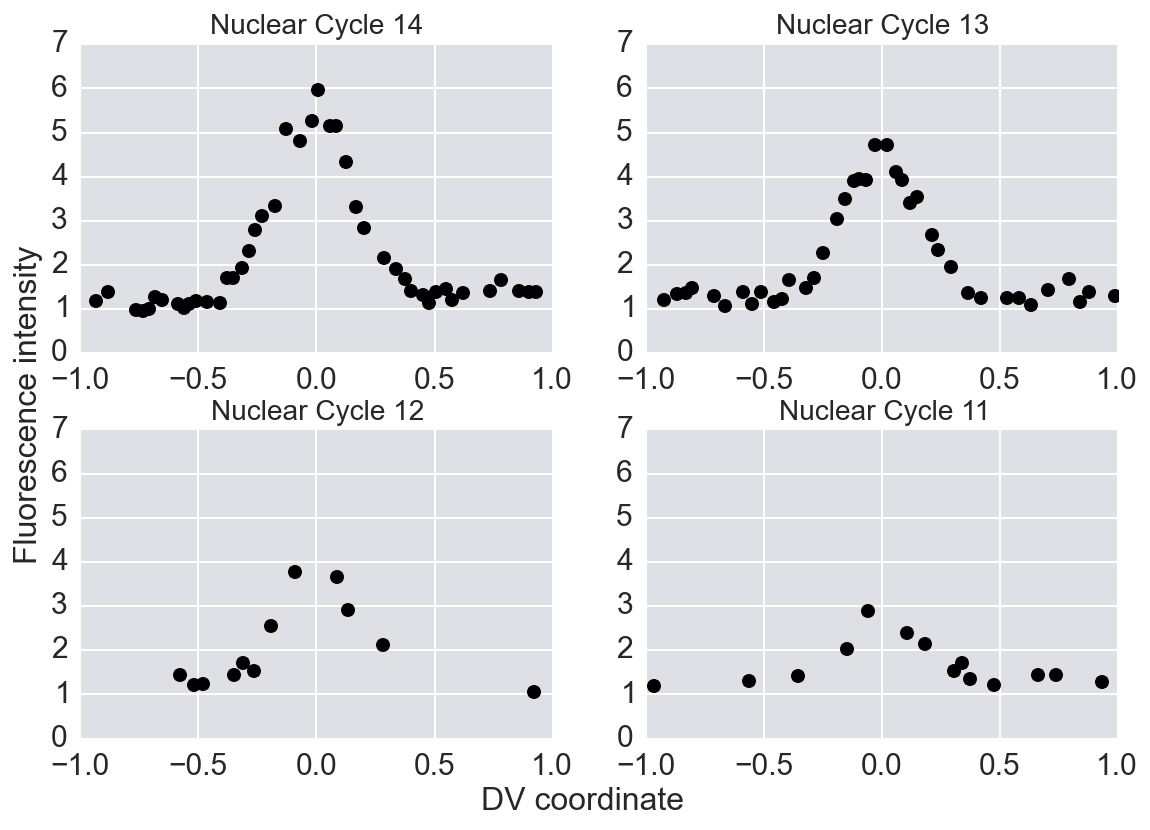

In [169]:
# For convenience, slice the original tidy DataFrame by nuclear cycle
nc14 = TidyData[TidyData['NuclearCycle']==14]
nc13 = TidyData[TidyData['NuclearCycle']==13]
nc12 = TidyData[TidyData['NuclearCycle']==12]
nc11 = TidyData[TidyData['NuclearCycle']==11]

# Make subplots
f, ax = plt.subplots(2, 2)

f.tight_layout()
ax[0,0].plot(nc14['DVCoordinate'], nc14['Intensity'], marker='o', linestyle='none', color='black')
ax[0,0].set_ylim([0,7.0])
ax[0,0].set_title('Nuclear Cycle 14', fontsize=14)
ax[0,1].plot(nc13['DVCoordinate'], nc13['Intensity'], marker='o', linestyle='none', color='black')
ax[0,1].set_ylim([0,7.0])
ax[0,1].set_title('Nuclear Cycle 13', fontsize=14)
ax[1,0].plot(nc12['DVCoordinate'], nc12['Intensity'], marker='o', linestyle='none', color='black')
ax[1,0].set_ylim([0,7.0])
ax[1,0].set_xlim([-1.0,1.0])
ax[1,0].set_title('Nuclear Cycle 12', fontsize=14)
ax[1,1].plot(nc11['DVCoordinate'], nc11['Intensity'], marker='o', linestyle='none', color='black')
ax[1,1].set_ylim([0,7.0])
ax[1,1].set_title('Nuclear Cycle 11', fontsize=14)

# Set common labels
f.text(0.5, 0.0, 'DV coordinate', ha='center', va='center', fontsize=16)
f.text(0.02, 0.5, 'Fluorescence intensity', ha='center', va='center', rotation='vertical', fontsize=16)

The data appear to roughly follow the shape of a bell curve. We expect that this is why the authors chose to fit the data with a Gaussian function. An additional parameter for background is necessary because the fluorescence does not go to zero, i.e., there is a basal level of Dorsal expression even in the dorsal-most cells. Other functions that have a similar shape to a Gaussian function include the Lorentzian function and the Voigt profile: all three have a peak in the middle and tail off symmetrically on either side. However, the Lorentzian function tails off more sharply than the Gaussian function, while Voigt is somewhere in the middle. Gaussian seems like a reasonable choice for a first regression attempt, but if the regression curve looks too wide relative to the amplitude, it could be worthwhile to try the other functions. 

**b)**  We are asked to write down expressions for the likelihood, prior, and posterior for a regression of these data.

First, the likelihood. We assume that the data vary from our model in a Gaussian manner. (This assumption is based on the central limit theorem, which is applicable in this case because many processes contribute to noise in the expression of a gene - e.g. the binding of transcription factors, the binding of the polymerase, errors in transcription, binding to the ribosome, etc.). Thus, our likelihood is given by:

\begin{align}
P(D \mid A, B, s, \sigma, I) = \prod_{i\in D} \frac{1}{\sqrt{2\pi\sigma^2}}\,
\exp\left[-\frac{(F_i - F(c_i;A, B, s))^2}{2\sigma^2}\right],
\end{align}

where

\begin{align}
F(c; A, B, s) = A \exp\left[-\frac{c^2}{2s^2}\right] \, + \, B
\end{align}

Note: $F(c; A, B, s)$ is the general form of a Gaussian-plus-background function. $A$ controls the amplitude (maximum value) of the function, $s$ controls the width (this is the value that Reeves et al. use to quantify the width of the Dorsal-Venus gradient), and $B$ is the background. 

Next, the prior. We want the most uninformative priors for each of the parameters, since we assume that we do not know anything about expression of Dorsal in this system *a priori* and we want to avoid biasing the posterior distribution. We have four parameters: $A, B, s, \sigma$. We choose a Jeffreys prior for $A$, $s$, and $\sigma$ because they are scaling parameters. $B$ is a location parameter (it moves the Gaussian curve up or down without changing the shape of the curve), so we choose a uniform prior for $B$. A quick look at our dataset reveals that the minimum fluorescence intensity is 0.9505. 

In [170]:
TidyData['Intensity'].min()

0.9505

We will set the lower bound for $B$ as zero because it doesn't make sense physically to have a negative background signal, and we will set the upper bound of $B$ to be well beyond the minimum recorded fluorescence intensity so that the posterior will be vanishingly small at the upper bound. We arbitrarily choose this upper bound to be 10. So our prior can be written as:

\begin{align}
P(A, B, s, \sigma \mid I) = P(A \mid I)P(B \mid I)P(s \mid I)P(\sigma \mid I) = \left\{
\begin{array}{cl}
(As\sigma)^{-1} & 0 \leq B \leq 10, \, A > 0, \, s > 0, \, \sigma > 0\\
0 & \mathrm{otherwise}
\end{array}
\right.
\end{align}

Now we can put the likelihood and prior together to write an expression for the posterior. We don't care about the normalization constant given by $P(D \mid I)$, so we will write the posterior as a statement of proportionality: 

\begin{align}
P(A, B, s, \sigma \mid D, I) \propto\frac{1}{\sigma^{n+1}}
\exp\left[-\frac{1}{2\sigma^2}\sum_{i\in D}(F_i - F(c_i; A, B, s))^2\right],
\end{align}

where

\begin{align}
F(c; A, B, s) = A \exp\left[-\frac{c^2}{2s^2}\right] \, + \, B
\end{align}

Marginalizing the posterior over $\sigma$ gives a Student-t distribution:

\begin{align}
P(A, B, s \mid D, I) \propto \left(\sum_{i\in D}(F_i - F(c_i; A, B, s)^2\right)^{-\frac{n}{2}} .
\end{align}

**c)** First, let's define a Python function for our theoretical model.

In [171]:
def fluor(c, A, B, s):
    """
    Theoretical model for fluorescence intensity (i.e. Dorsal expression) as a function of position c
    along the DV coordinate axis. 
    """
    return A * np.exp(-(c**2)/(2 * s**2)) + B

Next, we define a residual function, where the residual is the difference between the theoretical model prediction and the measured fluorescence intensity. 

In [172]:
def resid(p, c, f):
    """
    Residuals for Dorsal gradient model.
    """
    # Unpack parameters
    A, B, s = p
    
    # Compute residuals
    return f - fluor(c, A, B, s)

We have to provide an initial guess for the parameter values. Looking at the data in our plot above for nuclear cycle 14 (part **a**), we guess $A = 6.0, \, B = 1.0, \, s = 0.25$. (Remember that $A$ is the amplitude, or approximately the maximum fluorescence value; $B$ is the background, which is approximately the mimimum value; and $s$ is the width of the bell curve.) We make our guesses for the parameters for the other nuclear cycles in a similar manner.

In [173]:
# Initial parameter guesses. The sub-arrays are for nuclear cycles 14, 13, 12, and 11 in that order.
p0 = np.array([[6.0, 1.0, 0.25],[5.0, 1.0, 0.25], [4.0, 1.0, 0.25], [3.0, 1.0, 0.25]])

Now we can use `scipy.optimize.leastsq()` to compute the MAP.

In [174]:
# First define a function for log of the posterior, 
# to be used when calculating error bars for the regression parameters
def log_post(p, c, f):
    """
    Compute log of posterior for single set of parameters.
    p[0] = A
    p[1] = B
    p[2] = s
    """
    # Unpack parameters
    A, B, s = p
    
    # Theoretical spindle length
    f_theor = fluor(c, A, B, s)
    
    return -len(c) / 2 * np.log(np.sum((f - f_theor)**2))

# Extra arguments as a tuple
args = ((nc14['DVCoordinate'], nc14['Intensity']),(nc13['DVCoordinate'], nc13['Intensity']),
        (nc12['DVCoordinate'], nc12['Intensity']),(nc11['DVCoordinate'], nc11['Intensity']))

A_list = []
B_list = []
s_list = []
cov = []

# Compute the MAP
for i in range(0,4):
    popt, _ = scipy.optimize.leastsq(resid, p0[i], args=args[i])

    # Extract the values
    A, B, s = popt
    A_list.append(A)
    B_list.append(B)
    s_list.append(s)

    # Instantiate Hessian for log posterior
    hes_fun = ndt.Hessian(log_post)

    # Compute Hessian at MAP
    hes = hes_fun(popt, args[i][0], args[i][1])
    
    # Compute the covariance matrix
    cov.append(list(-np.linalg.inv(hes)))

# Print results
print("""
Most probable parameters for nuclear cycle 14 (≈ 68% of total probability)
--------------------------------------------------------------------------
A = {0:.2f} ± {1:.2f}
B = {2:.2f} ± {3:.2f}
s = {4:.2f} ± {5:.2f}
""".format(A_list[0], np.sqrt(cov[0][0][0]), 
           B_list[0], np.sqrt(cov[0][1][1]), 
           s_list[0], np.sqrt(abs(cov[0][2][2]))))

print("""
Most probable parameters for nuclear cycle 13 (≈ 68% of total probability)
--------------------------------------------------------------------------
A = {0:.2f} ± {1:.2f}
B = {2:.2f} ± {3:.2f}
s = {4:.2f} ± {5:.2f}
""".format(A_list[1], np.sqrt(cov[1][0][0]), 
           B_list[1], np.sqrt(cov[1][1][1]), 
           s_list[1], np.sqrt(abs(cov[1][2][2]))))

print("""
Most probable parameters for nuclear cycle 12 (≈ 68% of total probability)
--------------------------------------------------------------------------
A = {0:.2f} ± {1:.2f}
B = {2:.2f} ± {3:.2f}
s = {4:.2f} ± {5:.2f}
""".format(A_list[2], np.sqrt(cov[2][0][0]), 
           B_list[2], np.sqrt(cov[2][1][1]), 
           s_list[2], np.sqrt(abs(cov[2][2][2]))))

print("""
Most probable parameters for nuclear cycle 11 (≈ 68% of total probability)
--------------------------------------------------------------------------
A = {0:.2f} ± {1:.2f}
B = {2:.2f} ± {3:.2f}
s = {4:.2f} ± {5:.2f}
""".format(A_list[3], np.sqrt(cov[3][0][0]), 
           B_list[3], np.sqrt(cov[3][1][1]), 
           s_list[3], np.sqrt(abs(cov[3][2][2]))))


Most probable parameters for nuclear cycle 14 (≈ 68% of total probability)
--------------------------------------------------------------------------
A = 4.26 ± 0.11
B = 1.24 ± 0.04
s = 0.16 ± 0.11


Most probable parameters for nuclear cycle 13 (≈ 68% of total probability)
--------------------------------------------------------------------------
A = 3.25 ± 0.08
B = 1.28 ± 0.03
s = 0.16 ± 0.12


Most probable parameters for nuclear cycle 12 (≈ 68% of total probability)
--------------------------------------------------------------------------
A = 2.82 ± 0.13
B = 1.25 ± 0.00
s = 0.15 ± 0.01


Most probable parameters for nuclear cycle 11 (≈ 68% of total probability)
--------------------------------------------------------------------------
A = 1.48 ± 0.13
B = 1.32 ± 0.05
s = 0.15 ± 0.02



Note that $s$ is the parameter that quantifies the width of the Dorsal-Venus gradient. It seems that the width of the gradient remains constant across nuclear cycles.

Now we can plot the gradients corresponding to the most probable parameter values along with the experimentally observed data points. (Sidenote: omg `seaborn` has the xckd color names!) 

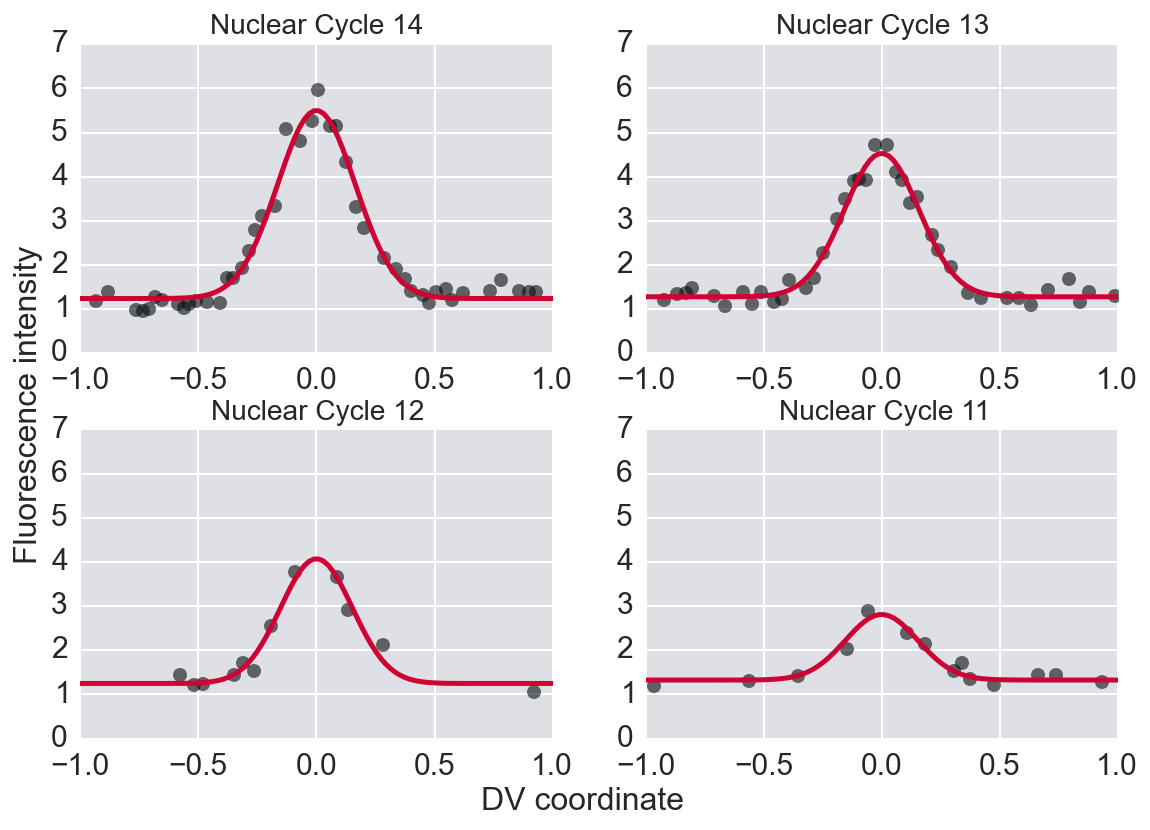

In [175]:
# Values of DV coordinate to plot
dv_plot = np.linspace(-1, 1, 100)

# Theoretical gradients with the most probable parameter values
fluor_theor14 = fluor(dv_plot, A_list[0], B_list[0], s_list[0])
fluor_theor13 = fluor(dv_plot, A_list[1], B_list[1], s_list[1])
fluor_theor12 = fluor(dv_plot, A_list[2], B_list[2], s_list[2])
fluor_theor11 = fluor(dv_plot, A_list[3], B_list[3], s_list[3])

# Make subplots with the experimental data and theoretical gradients
f, ax = plt.subplots(2, 2)

f.tight_layout()
ax[0,0].plot(nc14['DVCoordinate'], nc14['Intensity'], marker='o', linestyle='none', 
             color=sns.xkcd_rgb['almost black'], alpha=0.6)
ax[0,0].plot(dv_plot, fluor_theor14, '-', color=sns.xkcd_rgb['cherry'])
ax[0,0].set_ylim([0,7.0])
ax[0,0].set_title('Nuclear Cycle 14', fontsize=14)

ax[0,1].plot(nc13['DVCoordinate'], nc13['Intensity'], marker='o', linestyle='none', 
             color=sns.xkcd_rgb['almost black'], alpha=0.6)
ax[0,1].plot(dv_plot, fluor_theor13, '-', color=sns.xkcd_rgb['cherry'])
ax[0,1].set_ylim([0,7.0])
ax[0,1].set_title('Nuclear Cycle 13', fontsize=14)

ax[1,0].plot(nc12['DVCoordinate'], nc12['Intensity'], marker='o', linestyle='none', 
             color=sns.xkcd_rgb['almost black'], alpha=0.6)
ax[1,0].plot(dv_plot, fluor_theor12, '-', color=sns.xkcd_rgb['cherry'])
ax[1,0].set_ylim([0,7.0])
ax[1,0].set_title('Nuclear Cycle 12', fontsize=14)

ax[1,1].plot(nc11['DVCoordinate'], nc11['Intensity'], marker='o', linestyle='none', 
             color=sns.xkcd_rgb['almost black'], alpha=0.6)
ax[1,1].plot(dv_plot, fluor_theor11, '-', color=sns.xkcd_rgb['cherry'])
ax[1,1].set_ylim([0,7.0])
ax[1,1].set_title('Nuclear Cycle 11', fontsize=14)

# Set common labels
f.text(0.5, 0.0, 'DV coordinate', ha='center', va='center', fontsize=16)
f.text(0.02, 0.5, 'Fluorescence intensity', ha='center', va='center', rotation='vertical', fontsize=16)

**d)** First we read in the dataset as a Pandas `DataFrame` with a `MultiIndex` for the columns.

In [176]:
df2 = pd.read_csv('data/reeves_gradient_width_various_methods.csv', comment='#', header=[0,1])
df2.head()

wt                dl1/+; dl-venus/+                          \
  wholemounts cross-sections       anti-Dorsal anti-Venus Venus (live)   
0      0.1288         0.1327            0.1482     0.1632       0.1666   
1      0.1554         0.1457            0.1503     0.1671       0.1753   
2      0.1306         0.1447            0.1577     0.1704       0.1705   
3      0.1413         0.1282            0.1711     0.1779          NaN   
4      0.1557         0.1487            0.1342     0.1483          NaN   

  dl1/+; dl-gfp/+                      
      anti-Dorsal anti-GFP GFP (live)  
0          0.2248   0.2389     0.2412  
1          0.1891   0.2035     0.1942  
2          0.1705   0.1943     0.2186  
3          0.1735   0.2000     0.2104  
4          0.2135   0.2560     0.2463

Next, we tidy the data so that we will be able to work with them.

In [195]:
TidyData2 = pd.melt(df2)
TidyData2.columns = ['Genotype', 'VisualizationMethod', 'GradientWidth']
TidyData2 = TidyData2.dropna().reset_index(drop=True)

# Rename the anti-Dorsal method to distinguish between Venus and GFP fusion genotypes, otherwise our grouped boxplot 
# has a weird gap between anti-Dorsal and the other methods under the GFP fusion genotype
inds = (TidyData2.Genotype=='dl1/+; dl-gfp/+')
gfp = TidyData2[inds].replace(to_replace={'anti-Dorsal':'anti-Dorsal (dl1/+; dl-gfp/+)'})
inds2 = (TidyData2.Genotype !='dl1/+; dl-gfp/+') 
TidyData2 = pd.concat((TidyData2[inds2], gfp))
TidyData2.head()

,Genotype,VisualizationMethod,GradientWidth
0,wt,wholemounts,0.1288
1,wt,wholemounts,0.1554
2,wt,wholemounts,0.1306
3,wt,wholemounts,0.1413
4,wt,wholemounts,0.1557


We decided to display the data in a boxplot grouped by genotype. We chose a boxplot over a stripplot because in this case, we found the boxplot to be cleaner and easier to understand at a glance; in some of the groups with lots of datapoints, the data were too tightly clustered to be easily distinguished on a stripplot, even with `jitter=True`. On the other hand, the trade-off of choosing a boxplot is that we lose information about the differing numbers of samples across the different visualization methods.

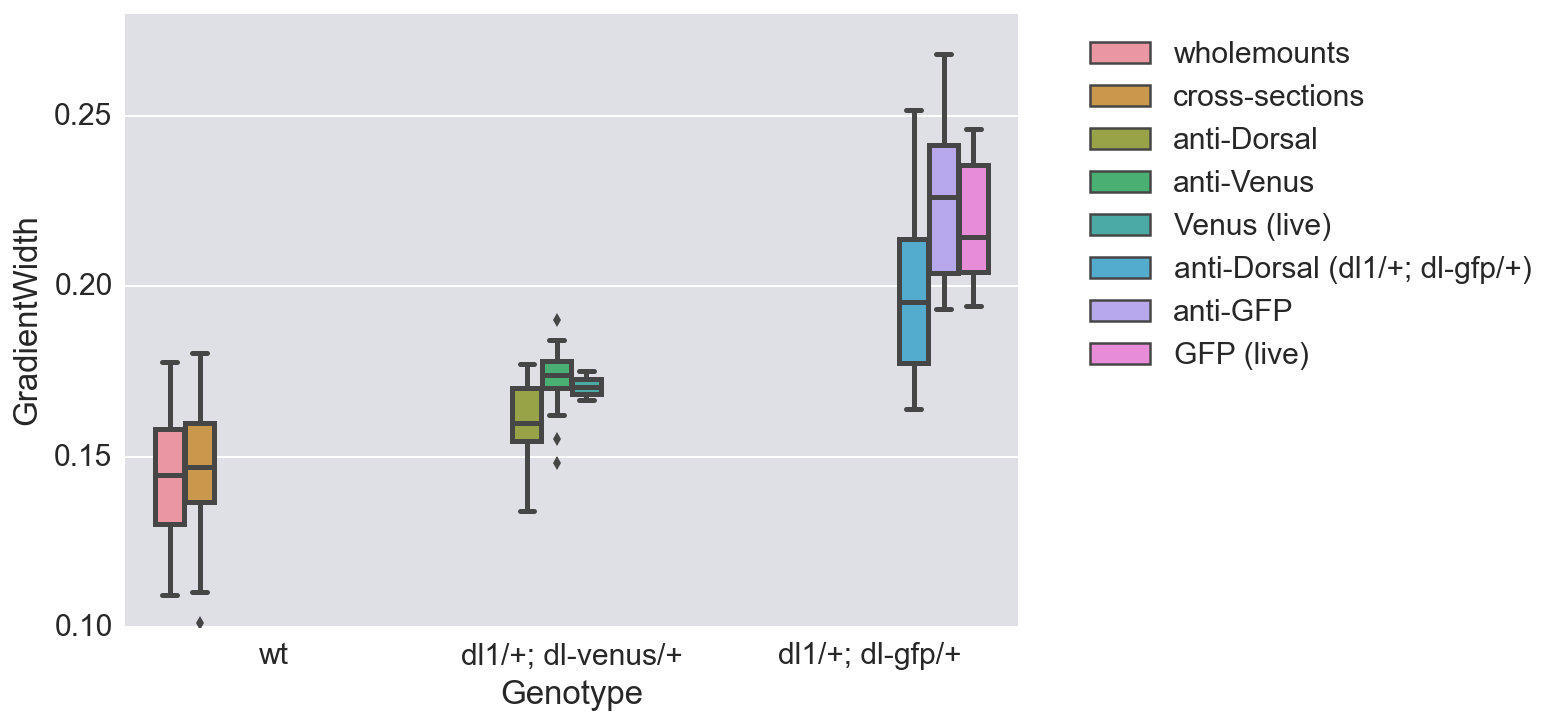

In [196]:
# Make a grouped boxplot 
ax = sns.boxplot(x=TidyData2['Genotype'], y=TidyData2['GradientWidth'], hue=TidyData2['VisualizationMethod'])
# Move the legend outside the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc=0)

Now we want to more directly compare the wild-type cross-section method with anti-Venus. 

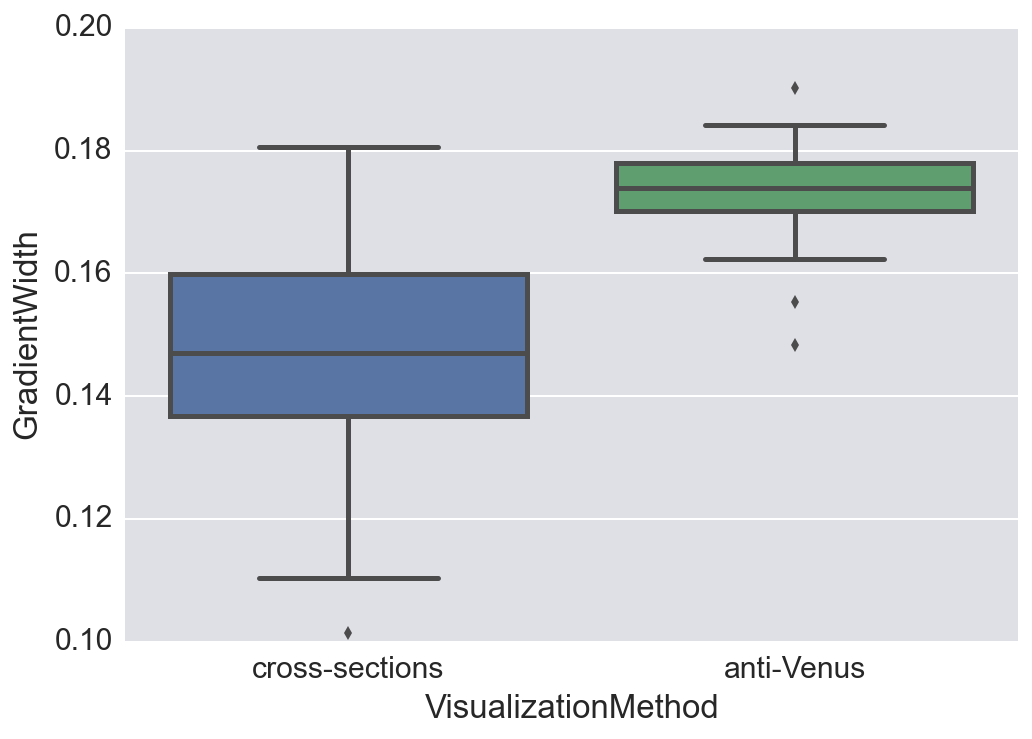

In [179]:
# For the sake of convenience for plotting, create new DataFrame with only the samples of interest
inds = (TidyData2.Genotype=='wt') & (TidyData2.VisualizationMethod=='cross-sections')
inds2 = (TidyData2.Genotype=='dl1/+; dl-venus/+') & (TidyData2.VisualizationMethod=='anti-Venus')
WtVenus = pd.concat((TidyData2[inds], TidyData2[inds2]))

# Make boxplot
ax = sns.boxplot(x=WtVenus['VisualizationMethod'], y=WtVenus['GradientWidth'])

It looks like there may be some difference between the two groups, but rather than try to guess by sight whether the difference is large enough to have concerns about using the Venus fusion to study the Dorsal gradient, we will calculate the effect size using Cohen's d. (Note: We recognize that this will compare the means of the two groups, whereas the boxplots show the medians. We are not too concerned about this inconsistency in our analysis, especially since the boxplots show that the data are fairly symmetrical about the medians -- and even though there are technically outliers, they are not so extreme or one-sided that we expect them to bias the mean too much. We expect the means to be similar to the medians.)

In [180]:
def pooled_std(data1, data2):
    """
    Calculate the pooled standard deviation for two independent samples.
    The data should be in Pandas Series.
    """
    return np.sqrt(((len(data1)-1)*(data1.std()**2)+(len(data2)-1)*(data2.std()**2))/(len(data1)+len(data2)-2))

def cohen_d(data1, data2):
    """
    Calculate Cohen's d for two independent samples.
    The data should be in Pandas DataFrames.
    """
    return (data1.mean() - data2.mean())/pooled_std(data1, data2)

# Calculate effect size for wild-type cross-sections and anti-Venus
effect_size = abs(cohen_d(WtVenus[WtVenus['VisualizationMethod']=='cross-sections'], 
                      WtVenus[WtVenus['VisualizationMethod']=='anti-Venus']))

print('Effect size = ' + str(effect_size[0]))

Effect size = 1.61423742555


We think an effect size of approximately 1.6 could be considered "medium" in this case; we might consider an effect size of 2 or greater to be "large". Hence, we do not feel confident saying, based on the effect size, that there either is or is not reason to be concerned about the difference between the two groups. However, our biological intuition says that because the Venus fusion rescues the null mutant, it should be a reasonable proxy for wild-type. (In fact, this intuition shaped our decision not to interpret the effect size as "medium" rather than "large".) We prefer to rely on our biological intuition in this case, not least because the definition of "small," "medium," and "large" effect sizes is so subjective and (often) ultimately arbitrary.  